# Deep Learning for Computer Vision:  Assignment 2


## Computer Science: COMS W 4995 004


## Due: February 27, 2018

#### Problem

You are given the noisy XOR data generated for you below. Your task is to implement a multi-layer perceptron binary classifier with one hidden layer. For the activiation function of the hidden units use ReLu or leaky ReLu. For the loss function use a softplus on a linear output layer as we did in class.

a) Implement each layer of the network as a separate function with both forward propagation and backpropagation. 

b) Train the network using stochastic gradient descent with mini-batches.  

c) Show the decision regions of the trained classifier by densely generating points in the plane and color coding these points with the binary labels. 

d) Repeat (b) and (c) varying the number of hidden units: 3, 16, 512. Discuss how the number of hidden units affects the solution.

e) Try choosing your own loss function (without asking me or the TAs what you should choose), repeating (d).

f) Now try with three inputs, generating your own training and validation data. (For this XOR the output should be a 1 if and only if exactly one of the inputs is 1. But make the training data noisey as before.) Use softplus loss. Do not try to show the decision regions, instead generate a validation set in the same manner as the training set, classify the samples, and compute the classification accuracy.

If you are struggling to get the network to converge, experiment with different learning rates.

Grading: a-d = 85%, e=10%, f=5%. 

#### NOTE:  Do not to use keras, tensorflow, pytorch, sklearn, etc. to do this.  You must build the machine learning components from scratch.



Let's start by importing some libraries.

In [476]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

Let's make up some noisy XOR data.

In [501]:
data = pd.DataFrame(np.zeros((5000, 3)), columns=['x1', 'x2', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0,1)
    x2 = 1.0 * random.randint(0,1)
    y = 1.0 * np.logical_xor(x1 == 1 , x2 == 1)
    x1 = x1 + 0.18 * np.random.normal()
    x2 = x2 + 0.18 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = y
        
data.head()

,x1,x2,y
0,-0.225245,0.115329,0.0
1,0.184413,1.030207,1.0
2,0.914806,-0.179590,1.0
3,0.081391,0.877957,1.0
4,0.860010,0.811776,0.0


Let's message this data into a numpy format.

In [502]:
# set X (training data) and y (target variable)
cols = data.shape[1]
X = data.iloc[:,0:cols-1]
y = data.iloc[:,cols-1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
X = np.matrix(X.values)
y = np.matrix(y.values)

Let's make a sloppy plotting function for our binary data.

In [503]:
# Sloppy function for plotting our data
def plot_data(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    y_predict = y_prob > 0.5
    indices_0 = [k for k in range(0, X.shape[0]) if not y_predict[k]]
    indices_1 = [k for k in range(0, X.shape[0]) if y_predict[k]]

    ax.plot(X[indices_0, 0], X[indices_0,1], marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Noisy XOR')
    plt.show()

Now let's plot it.

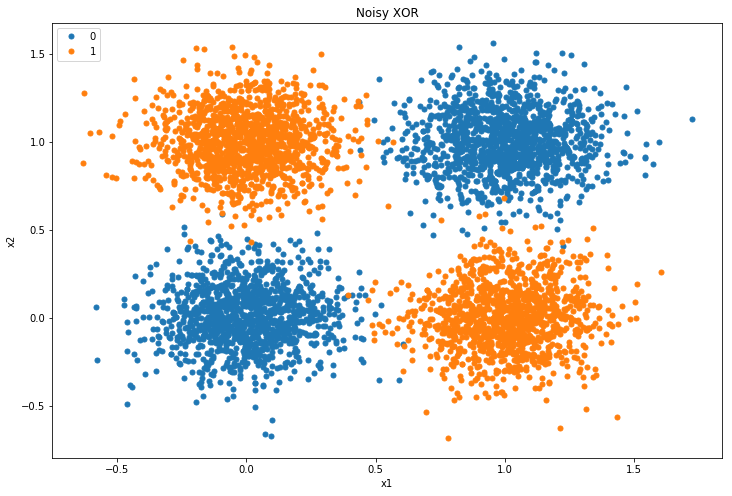

In [504]:
plot_data(X, y)

Now let's create functions for forward and backward prop through the layers and we are off...

In [5]:
# Add a dimension for the bias
# X = np.c_[X, np.ones(X.shape[0])]

In [505]:
def relu(a):
    a[a < 0] = 0
    return a

def leaky_relu(a, eps):
    a[np.where(a < 0)] *= eps
    return a

In [506]:
def sigmoid(z):
    return 1.0/(1.0 + np.exp(-z))

In [507]:
def softplus(data, labels, a):
    loss = np.multiply(1 - 2*labels, a)
    loss = np.log(1 + np.exp(loss))
    return loss

In [532]:
class Network():
    def __init__(self, in_units = 2, hidden_units = 3, 
                 out_units = 1, lr = 0.1,
                 batch_size = 100, debug = False):

        # Network specifications
        self.in_units = in_units
        self.hidden_units = hidden_units
        self.batch_size = batch_size
        self.out_units = out_units
        self.lr = lr
        self.debug = debug
        
        # Initialize network parameters
        w1 = np.random.rand(self.hidden_units, self.in_units) - 0.7
        w2 = np.random.rand(self.out_units, self.hidden_units) - 0.7
        b1 = np.zeros((hidden_units, 1))
        b2 = np.zeros((self.out_units, 1))
        
        self.weights = [w1, w2]
        self.bias = [b1, b2]
        
        # Initialize batchwise layer outputs as empty
        self.linear1 = []
        self.relu1 = []
        self.eps = 0.001
        self.linear2 = []
        
        # Initialize batchwise gradients as empty
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
    
    # Feedforward for entire batch
    def forward(self, data, save = True):
        self.linear1 = []
        self.relu1 = []
        self.linear2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::]
            x = x.reshape(self.in_units, 1)
            self._forward(x, idx, save)
        return np.array(self.linear2)
    
    # Feedforward for a single data point
    def _forward(self, x, idx, save = True):

        linear1 = np.dot(self.weights[0], x) + self.bias[0]
        relu1 = leaky_relu(linear1, self.eps)
        linear2 = np.dot(self.weights[1], relu1) + self.bias[1]
        
        self.linear2.append(linear2)
        self.linear1.append(linear1)
        self.relu1.append(relu1)
        
        if self.debug and idx == 0:
            print("\n---- PRINT FORWARD DATA ----\n")
            print("x = ", x, x.shape)
            print("weights1 = ", self.weights[0], self.weights[0].shape)
            print("linear1 = ", linear1, linear1.shape)
            print("relu1 = ", relu1, relu1.shape)
            print("weights2 = ", self.weights[1], self.weights[1].shape)
            print("linear2 = ", linear2, linear2.shape)
        
        return linear2
        
    # Backprop for entire batch
    def backward(self, L, data, labels):
        if (data.shape[0] != labels.shape[0]):
            print("Data and labels shapes mismatch")
            return None
        
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::]
            x = x.reshape(self.in_units, 1)
            y = labels[idx]
            self._backward(L, x, y, idx)

        self.grad_weights = [np.mean(self.allgrad_weight1),
                             np.mean(self.allgrad_weight2)]
        self.grad_bias = [np.mean(self.allgrad_bias1),
                          np.mean(self.allgrad_bias2)]
        
    # Backprop for a single data point
    def _backward(self, L, x, y, idx):
        r = 1.0 - 2*y
        
        grad_bias2 = sigmoid(r * self.linear2[idx]) * r
        grad_weight2 = np.multiply(grad_bias2, self.relu1[idx])
        grad_relu1 = grad_bias2 * self.weights[1]
        grad_linear1 = grad_relu1.T
        grad_linear1[np.where(self.relu1[idx] <= 0)] *= self.eps
        grad_weight1 = np.dot(grad_linear1, x.T)
        grad_bias1 = grad_linear1
            
        self.allgrad_weight1.append(grad_weight1)
        self.allgrad_weight2.append(grad_weight2)
        self.allgrad_bias1.append(grad_bias1)
        self.allgrad_bias2.append(grad_bias2)
        
        if (self.debug and idx == 0):
            print("\n---- PRINT BACKWARD DATA ----\n")
            print("linear2 = ", self.linear2[idx])
            print("r:", r, "y:", y)
            print("weight2:", self.weights[1])
            print("grad_bias2:", grad_bias2)
            print("grad_weight2:", grad_weight2)
            print("weight1:", self.weights[0])
            print("grad_relu1:", grad_relu1)
            print("grad_linear1:", grad_linear1)
            print("grad_weight1:", grad_weight1)
            print("grad_bias1:", grad_bias1)
    
    # Update mini batch weights
    def update_weights(self, lr = None):
        if (lr):
            self.lr = lr
        self.weights[0] -= (self.lr * self.grad_weights[0])
        self.weights[1] -= (self.lr * self.grad_weights[1])
        self.bias[0] -= (self.lr * self.grad_bias[0])
        self.bias[1] -= (self.lr * self.grad_bias[1])
        
    # Predict labels
    def predict(self, data):
        out = self.forward(data, save = False)
        out[out >= 0] = 1
        out[out < 0] = 0
        return out
    
    # Compute accuracy
    def accuracy(self, data, labels):
        predicted_labels = self.predict(data).reshape(-1, 1)
        matches = np.where(predicted_labels == labels)
        return np.sum(labels == predicted_labels) / labels.shape[0] * 100.0

In [509]:
# Split indexes for training and testing
def split_data(data_X, data_y, test_split = 5):
    train_n = data_X.shape[0]
    test_n = batch_size * test_split
    train_n = train_n - test_n
    train_idx = np.arange(train_n)
    test_idx = np.arange(train_n, train_n + test_n)
    print("Split (train/test): (%d/%d)" %(train_n, test_n))
    data, labels = data_X[train_idx, ::], data_y[train_idx, ::]
    test_data, test_labels = data_X[test_idx, ::], data_y[test_idx, ::]
    return data, labels, test_data, test_labels

In [540]:
# Train an epoch
def train(net, epoch, data, labels, batch_size, 
          adaptive_lr = False, debug = False):
    train_n = data.shape[0]
    train_idx = np.arange(train_n)
    np.random.shuffle(train_idx)
    
    train_loss = []
    train_acc = []
    for i in range(0, train_n, batch_size):
        batch_idx = train_idx[i:i + batch_size]
        batch_X = data[batch_idx, ::]
        batch_y = labels[batch_idx, ::]
        
        # Feedforward
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        train_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        train_acc.append(acc)
        net.backward(loss, batch_X, batch_y)
        if adaptive_lr:
            lr = np.exp(-epoch * 0.01)
        else:
            lr = None
        net.update_weights(lr)
    
    if debug:
        print("Epoch %d, Train loss: %.4f" %(epoch, np.mean(train_loss)))
        print("Epoch %d, Train Accuracy: %.4f" %(epoch, np.mean(train_acc)))

In [528]:
# Test validation data
def test(net, test_data, test_labels, batch_size, debug = True):
    test_n = test_data.shape[0]
    test_idx = np.arange(test_n)
    test_loss = []
    test_acc = []
    for i in range(0, test_n, batch_size):
        batch_idx = test_idx[i:i + batch_size]
        batch_X = test_data[batch_idx, :]
        batch_y = test_labels[batch_idx, ::]
        a = net.forward(batch_X)
        loss = softplus(batch_X, batch_y, a.reshape(batch_size, 1))
        test_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        test_acc.append(acc)
        if debug:
            pass
#             print("Batch %d: %d/%d Accuracy: %f" %(i/batch_size, i, test_n, acc)) 

    if debug:
        print("Test loss:", np.mean(test_loss))
        print("Accuracy:", np.mean(test_acc))

In [541]:
# Define decision boundary
def plot_boundary(X, y_prob):
    
    fig, ax = plt.subplots(figsize=(12,8))
    ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#     indices_0 = np.where(y_prob <= 0.5)
#     indices_1 = np.where(y_prob > 0.5)
#     print(y_prob.shape)
    indices_0 = [k for k in range(0, X.shape[0]) if y_prob[k, ::] <= 0.5]
    indices_1 = [k for k in range(0, X.shape[0]) if y_prob[k, ::] > 0.5]

    ax.plot(X[indices_0, 0], X[indices_0,1], 'b', marker='o', linestyle='', ms=5, label='0')
    ax.plot(X[indices_1, 0], X[indices_1,1], 'y', marker='o', linestyle='', ms=5, label='1')

    ax.legend()
    ax.legend(loc=2)
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    ax.set_title('Decision Boundary')
    plt.show()

Network with 3 hidden units, Accuracy: 91.6%

In [544]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
seed = 6524
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 3

# Initialize network
net3 = Network(in_units = 2, hidden_units = hidden_units, lr = 0.1, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net3, epoch, data, labels, batch_size, 
          adaptive_lr = False, debug = False)
    
test(net3, test_data, test_labels, batch_size, debug = True)

Random seed: 6524
Split (train/test): (4750/250)
Test loss: 0.6077122491597403
Accuracy: 94.4


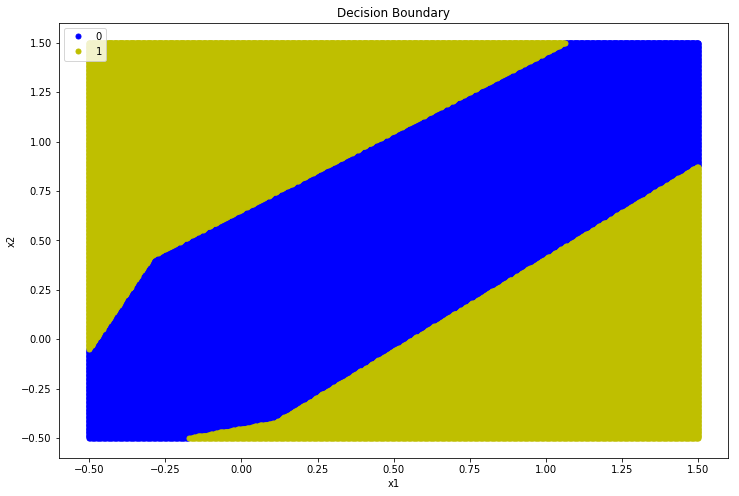

In [545]:
n = 500
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net3.predict(new_X)

plot_boundary(new_X, new_y)

In [516]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 8879
seed = 3581
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 16

# Initialize network
net16 = Network(hidden_units = hidden_units, lr = 0.1, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net16, epoch, data, labels, batch_size, debug = False)
    
test(net16, test_data, test_labels, batch_size, debug = True)

Random seed: 3581
Split (train/test): (4750/250)
Test loss: 0.5903963463066276
Accuracy: 89.6


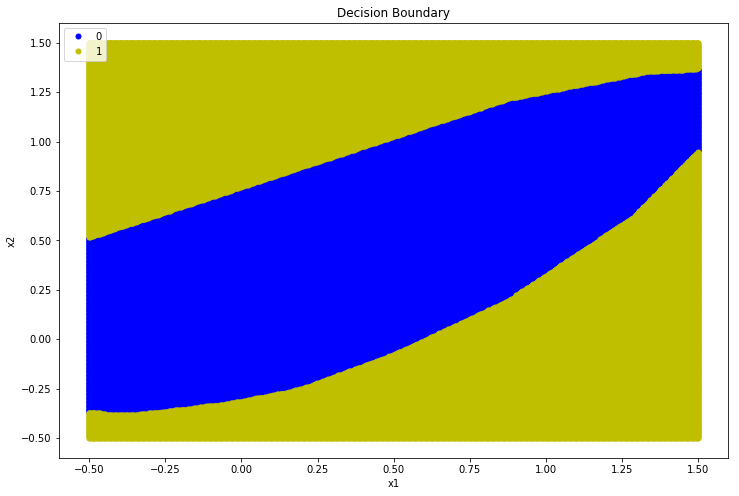

In [518]:
n = 500
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net16.predict(new_X)

new_labels = net16.predict(test_data)
plot_boundary(new_X, new_y)

In [524]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
seed = 2013
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 512

# Initialize network
net512 = Network(hidden_units = hidden_units, lr = 0.15, 
              batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net512, epoch, data, labels, batch_size, debug = True)
    test(net512, test_data, test_labels, batch_size, debug = True)
    
test(net512, test_data, test_labels, batch_size, debug = True)

Random seed: 2013
Split (train/test): (4750/250)
Epoch 0, Train loss: 1.0056
Epoch 0, Train Accuracy: 42.9263
Test loss: 0.795700550761356
Accuracy: 49.6
Epoch 1, Train loss: 0.7551
Epoch 1, Train Accuracy: 50.2947
Test loss: 0.7250057342578592
Accuracy: 60.0
Epoch 2, Train loss: 0.7064
Epoch 2, Train Accuracy: 60.2105
Test loss: 0.6917715864985279
Accuracy: 65.2
Epoch 3, Train loss: 0.6803
Epoch 3, Train Accuracy: 65.4947
Test loss: 0.6701244332289027
Accuracy: 67.2
Epoch 4, Train loss: 0.6588
Epoch 4, Train Accuracy: 68.0421
Test loss: 0.6495824310495654
Accuracy: 64.8
Epoch 5, Train loss: 0.6335
Epoch 5, Train Accuracy: 69.4947
Test loss: 0.6256714420666654
Accuracy: 80.0
Epoch 6, Train loss: 0.6032
Epoch 6, Train Accuracy: 85.3684
Test loss: 0.6017938368027894
Accuracy: 83.2
Epoch 7, Train loss: 0.5745
Epoch 7, Train Accuracy: 86.9684
Test loss: 0.5836357621823175
Accuracy: 82.0
Epoch 8, Train loss: 0.5532
Epoch 8, Train Accuracy: 86.1263
Test loss: 0.5701127159421283
Accuracy: 83.

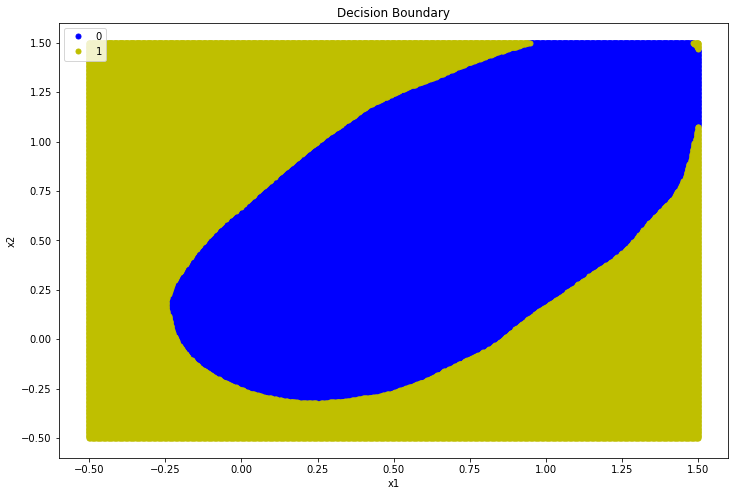

In [525]:
n = 500
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net512.predict(new_X)

plot_boundary(new_X, new_y)

In [547]:
class Network_cce():
    def __init__(self, in_units = 2, out_units = 1, 
                 hidden_units = 3, lr = 0.1,
                 batch_size = 100, debug = False):

        # Network specifications
        self.in_units = in_units
        self.hidden_units = hidden_units
        self.out_units = out_units
        self.batch_size = batch_size
        self.lr = lr
        self.debug = debug
        
        # Initialize network parameters
        w1 = np.random.rand(hidden_units, self.in_units) - 0.5
        w2 = np.random.rand(self.out_units, hidden_units) - 0.5
        b1 = np.zeros((hidden_units, 1))
        b2 = np.zeros((self.out_units, 1))
        
        self.weights = [w1, w2]
        self.bias = [b1, b2]
        
        # Initialize batchwise layer outputs as empty
        self.linear1 = []
        self.relu1 = []
        self.eps = 0.00
        self.linear2 = []
        
        # Initialize batchwise gradients as empty
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
    
    # Feedforward for entire batch
    def forward(self, data, save = True):
        self.linear1 = []
        self.relu1 = []
        self.linear2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::]
            x = x.reshape(self.in_units, 1)
            self._forward(x, idx, save)
        return np.array(self.linear2)
    
    # Feedforward for a single data point
    def _forward(self, x, idx, save = True):

        linear1 = np.dot(self.weights[0], x) + self.bias[0]
        relu1 = leaky_relu(linear1, self.eps)
        linear2 = np.dot(self.weights[1], relu1) + self.bias[1]
        
        self.linear2.append(linear2)
        self.linear1.append(linear1)
        self.relu1.append(relu1)
        
        if self.debug and idx == 0:
            print("\n---- PRINT FORWARD DATA ----\n")
            print("x = ", x, x.shape)
            print("weights1 = ", self.weights[0], self.weights[0].shape)
            print("linear1 = ", linear1, linear1.shape)
            print("relu1 = ", relu1, relu1.shape)
            print("weights2 = ", self.weights[1], self.weights[1].shape)
            print("linear2 = ", linear2, linear2.shape)
        
        return linear2
        
    # Backprop for entire batch
    def backward(self, L, data, labels):
        if (data.shape[0] != labels.shape[0]):
            print("Data and labels shapes mismatch")
            return None
        
        self.allgrad_weight1 = []
        self.allgrad_weight2 = []
        self.allgrad_bias1 = []
        self.allgrad_bias2 = []
        for idx in range(data.shape[0]):
            x = data[idx, ::]
            x = x.reshape(self.in_units, 1)
            y = labels[idx]
            self._backward(L, x, y, idx)

        self.grad_weights = [np.mean(self.allgrad_weight1),
                             np.mean(self.allgrad_weight2)]
        self.grad_bias = [np.mean(self.allgrad_bias1),
                          np.mean(self.allgrad_bias2)]
        
    # Backprop for a single data point
    def _backward(self, L, x, y, idx):
        eps = 0.01
        grad_bias2 = sigmoid(self.linear2[idx]) - y
#         grad_bias2 = 2*(y - self.linear2[idx])
        grad_weight2 = np.multiply(grad_bias2, self.relu1[idx])
        grad_relu1 = grad_bias2 * self.weights[1]
        grad_linear1 = grad_relu1.T
        grad_linear1[np.where(self.relu1[idx] <= 0)] *= self.eps
        grad_weight1 = np.dot(grad_linear1, x.T)
        grad_bias1 = grad_linear1
            
        self.allgrad_weight1.append(grad_weight1)
        self.allgrad_weight2.append(grad_weight2)
        self.allgrad_bias1.append(grad_bias1)
        self.allgrad_bias2.append(grad_bias2)
        
        if (self.debug and idx == 0):
            print("\n---- PRINT BACKWARD DATA ----\n")
            print("linear2 = ", self.linear2[idx])
            print("r:", r, "y:", y)
            print("weight2:", self.weights[1])
            print("grad_bias2:", grad_bias2)
            print("grad_weight2:", grad_weight2)
            print("weight1:", self.weights[0])
            print("grad_relu1:", grad_relu1)
            print("grad_linear1:", grad_linear1)
            print("grad_weight1:", grad_weight1)
            print("grad_bias1:", grad_bias1)
    
    # Update mini batch weights
    def update_weights(self, lr = None):
        if lr is not None:
            self.lr = lr
        self.weights[0] -= (self.lr * self.grad_weights[0])
        self.weights[1] -= (self.lr * self.grad_weights[1])
        self.bias[0] -= (self.lr * self.grad_bias[0])
        self.bias[1] -= (self.lr * self.grad_bias[1])
        
    # Predict labels
    def predict(self, data):
        out = self.forward(data, save = False)
        out[out >= 0] = 1
        out[out < 0] = 0
        return out
    
    # Compute accuracy
    def accuracy(self, data, labels):
        predicted_labels = self.predict(data).reshape(-1, 1)
        matches = np.where(predicted_labels == labels)
        return np.sum(labels == predicted_labels) / labels.shape[0] * 100.0

In [548]:
def categorical_cross_entropy(data, labels, out):
    n = data.shape[0]
    eps = 0.01
    L = - np.multiply(labels, np.log(sigmoid(out)))
    L = L - np.multiply(1.0 - labels, np.log(1.0 - sigmoid(out)))
    L = np.sum(L)/n
    return L

In [549]:
def quadratic(data, labels, out):
    L = np.square(labels - out)
    L = L / data.shape[0]
    return L

In [550]:
# Train an epoch
def train_cce(net, epoch, data, labels, batch_size, 
              adaptive_lr = False, debug = False):
    train_n = data.shape[0]
    train_idx = np.arange(train_n)
    np.random.shuffle(train_idx)
    
    train_loss = []
    train_acc = []
    for i in range(0, train_n, batch_size):
        batch_idx = train_idx[i:i + batch_size]
        batch_X = data[batch_idx, ::]
        batch_y = labels[batch_idx, ::]
        
        # Feedforward
        a = net.forward(batch_X)
        loss = categorical_cross_entropy(batch_X, batch_y, a.reshape(batch_size, 1))
#         loss = quadratic(batch_X, batch_y, a.reshape(batch_size, 1))
        train_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        train_acc.append(acc)
        net.backward(loss, batch_X, batch_y)
        if adaptive_lr:
            lr = np.exp(-epoch * 0.001)
        else:
            lr = None
        net.update_weights(lr)
    
    if debug:
        print("Epoch %d, Train loss: %.4f" %(epoch, np.mean(train_loss)))
        print("Epoch %d, Train Accuracy: %.4f" %(epoch, np.mean(train_acc)))

In [551]:
# Test validation data
def test_cce(net, test_data, test_labels, batch_size, debug = True):
    test_n = test_data.shape[0]
    test_idx = np.arange(test_n)
    test_loss = []
    test_acc = []
    for i in range(0, test_n, batch_size):
        batch_idx = test_idx[i:i + batch_size]
        batch_X = test_data[batch_idx, :]
        batch_y = test_labels[batch_idx, ::]
        a = net.forward(batch_X)
        loss = categorical_cross_entropy(batch_X, batch_y, a.reshape(batch_size, 1))
        test_loss.append(loss)
        acc = net.accuracy(batch_X, batch_y)
        test_acc.append(acc)
        if debug:
            pass
#             print("Batch %d: %d/%d Accuracy: %f" %(i/batch_size, i, test_n, acc)) 

    if debug:
        print("Test loss:", np.mean(test_loss))
        print("Accuracy:", np.mean(test_acc))

In [ ]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
seed = 6524
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 3

# Initialize network
net3_cce = Network_cce(hidden_units = hidden_units, lr = 0.1,
                       out_units = 1, batch_size = batch_size, 
                       debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train_cce(net3_cce, epoch, data, labels, batch_size, debug = False)
    
test_cce(net3_cce, test_data, test_labels, batch_size, debug = True)

Random seed: 6524
Split (train/test): (4750/250)


In [ ]:
n = 500
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net3_cce.predict(new_X)

plot_boundary(new_X, new_y)

In [459]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 6524
# seed = 5792
# seed = 6257
# seed = 2013
# seed = 9928
seed = 3581
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 100
num_epochs = 10
hidden_units = 16

# Initialize network
net16_cce = Network_cce(hidden_units = hidden_units, lr = 0.2, 
              out_units = 1, batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net16_cce, epoch, data, labels, batch_size, debug = False)
    
test(net16_cce, test_data, test_labels, batch_size, debug = True)

Random seed: 3581
Split (train/test): (4500/500)
Test loss: 0.5917829153853772
Accuracy: 91.6


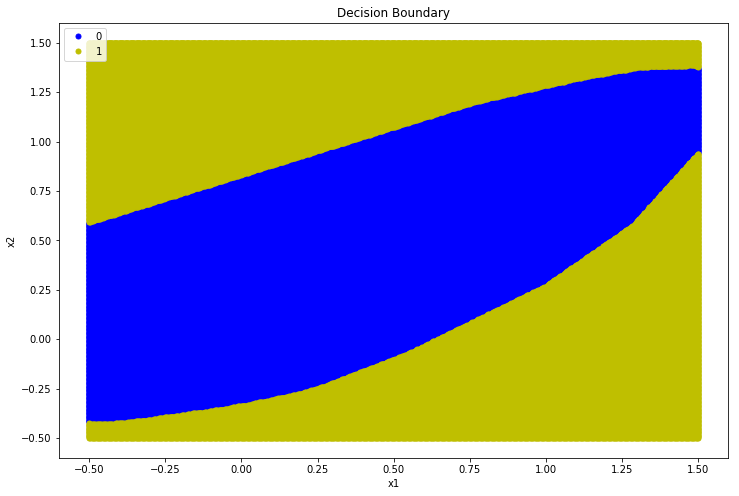

In [460]:
n = 500
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net16_cce.predict(new_X)

plot_boundary(new_X, new_y)

In [464]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 8128
# seed = 7900
# seed = 2247
# seed = 9928
# seed = 3581
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 512

# Initialize network
net512_cce = Network_cce(hidden_units = hidden_units, lr = 0.1, 
              out_units = 1, batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(X, y)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net512_cce, epoch, data, labels, batch_size, debug = True)
    test(net512_cce, test_data, test_labels, batch_size, debug = True)
    
test(net512_cce, test_data, test_labels, batch_size, debug = True)

Random seed: 8122
Split (train/test): (4750/250)
Epoch 0, Train loss: 1.1482
Epoch 0, Train Accuracy: 32.7579
Test loss: 0.8951070910662763
Accuracy: 27.6
Epoch 1, Train loss: 0.8540
Epoch 1, Train Accuracy: 26.5895
Test loss: 0.8140424720117364
Accuracy: 29.2
Epoch 2, Train loss: 0.7904
Epoch 2, Train Accuracy: 29.4947
Test loss: 0.7687065222086682
Accuracy: 28.8
Epoch 3, Train loss: 0.7583
Epoch 3, Train Accuracy: 29.6842
Test loss: 0.744976294741244
Accuracy: 30.8
Epoch 4, Train loss: 0.7391
Epoch 4, Train Accuracy: 30.6737
Test loss: 0.7307091424805192
Accuracy: 30.4
Epoch 5, Train loss: 0.7269
Epoch 5, Train Accuracy: 30.8211
Test loss: 0.7200071223890248
Accuracy: 34.0
Epoch 6, Train loss: 0.7193
Epoch 6, Train Accuracy: 33.1368
Test loss: 0.7144162115448214
Accuracy: 32.4
Epoch 7, Train loss: 0.7143
Epoch 7, Train Accuracy: 37.7053
Test loss: 0.7110551510276644
Accuracy: 31.2
Epoch 8, Train loss: 0.7111
Epoch 8, Train Accuracy: 36.1053
Test loss: 0.7082122248944568
Accuracy: 53.

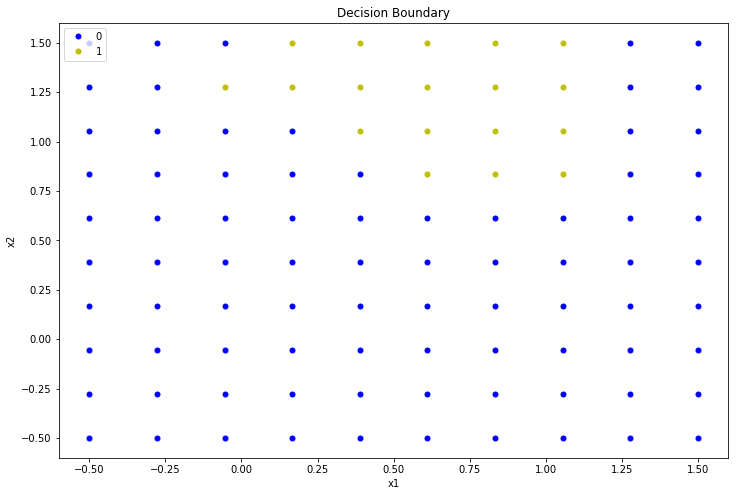

In [466]:
n = 10
idx = np.linspace(-0.5, 1.5, n)
x1, x2 = np.meshgrid(idx, idx)
new_X = np.zeros((n*n, 2))
new_X[:, 0] = x1.flatten()
new_X[:, 1] = x2.flatten()

new_y = net512_cce.predict(new_X)

plot_boundary(new_X, new_y)

In [467]:
data = pd.DataFrame(np.zeros((6000, 4)), columns=['x1', 'x2', 'x3', 'y'])

# Let's make up some noisy XOR data to use to build our binary classifier
for i in range(len(data.index)):
    x1 = 1.0 * random.randint(0, 1)
    x2 = 1.0 * random.randint(0, 1)
    x3 = 1.0 * random.randint(0, 1)
    xor = 1.0 * np.logical_xor(np.logical_xor(x1 == 1, x2 == 1), x3 == 1)
    x1 = x1 + 0.15 * np.random.normal()
    x2 = x2 + 0.15 * np.random.normal()
    x3 = x3 + 0.15 * np.random.normal()
    data.iloc[i,0] = x1
    data.iloc[i,1] = x2
    data.iloc[i,2] = x2
    data.iloc[i,3] = xor
        
data.head()

# set X (training data) and y (target variable)
cols = data.shape[1]
Xf = data.iloc[:, 0:cols - 1]
yf = data.iloc[:, cols - 1:cols]

# The cost function is expecting numpy matrices so we need to convert X and y before we can use them.  
Xf = np.matrix(Xf.values)
yf = np.matrix(yf.values)

In [471]:
# Random initialization that works for network with 3 hidden units
seed = int(np.random.rand(1) * 10000)
# seed = 6524
print("Random seed:", seed)
np.random.seed(seed)

# Network parameters
batch_size = 50
num_epochs = 10
hidden_units = 3

# Initialize network
net3_f = Network(in_units = Xf.shape[1], hidden_units = hidden_units, 
                     out_units = yf.shape[1], lr = 0.2, 
                     batch_size = batch_size, debug = False)

# Split Data into training and test sets
data, labels, test_data, test_labels = split_data(Xf, yf, test_split = 20)
print(data.shape, test_data.shape)

# Train the network for 'num_epochs'
for epoch in range(num_epochs):
    train(net3_f, epoch, data, labels, batch_size, debug = True)
    test(net3_f, test_data, test_labels, batch_size, debug = True)
    
test(net3_f, test_data, test_labels, batch_size, debug = True)

Random seed: 9391
Split (train/test): (5000/1000)
(5000, 3) (1000, 3)
Epoch 0, Train loss: 0.6932
Epoch 0, Train Accuracy: 51.1000
Test loss: 0.6948787631170269
Accuracy: 49.4
Epoch 1, Train loss: 0.6932
Epoch 1, Train Accuracy: 51.3000
Test loss: 0.6948262861849428
Accuracy: 49.4
Epoch 2, Train loss: 0.6931
Epoch 2, Train Accuracy: 51.5000
Test loss: 0.6955928401929163
Accuracy: 49.4
Epoch 3, Train loss: 0.6932
Epoch 3, Train Accuracy: 51.1600
Test loss: 0.6948470234211009
Accuracy: 49.4
Epoch 4, Train loss: 0.6930
Epoch 4, Train Accuracy: 51.2800
Test loss: 0.6939374030993845
Accuracy: 49.7
Epoch 5, Train loss: 0.6931
Epoch 5, Train Accuracy: 51.1000
Test loss: 0.6930292237901453
Accuracy: 49.8
Epoch 6, Train loss: 0.6932
Epoch 6, Train Accuracy: 51.5000
Test loss: 0.694451556036586
Accuracy: 49.4
Epoch 7, Train loss: 0.6931
Epoch 7, Train Accuracy: 50.9000
Test loss: 0.694037818942207
Accuracy: 49.6
Epoch 8, Train loss: 0.6931
Epoch 8, Train Accuracy: 51.2200
Test loss: 0.6939460415